# AVA Dataset Exploration
## Aesthetic Visual Analysis for Photography Evaluation

This notebook explores the AVA dataset to understand:
- Dataset structure and size
- Rating distribution and statistics
- Image characteristics
- Data quality and preprocessing needs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path
import random
from tqdm import tqdm

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Dataset paths
DATASET_ROOT = Path('../datasets')
IMAGES_PATH = DATASET_ROOT / 'images'
CSV_PATH = DATASET_ROOT / 'ground_truth_dataset.csv'
AVA_FILES_PATH = DATASET_ROOT / 'AVA_Files'

## 1. Load and Examine Dataset

In [2]:
# Load the ratings CSV
df = pd.read_csv(CSV_PATH)

print(f"Dataset Shape: {df.shape}")
print(f"Number of images: {len(df)}")
print(f"Number of rating columns: {len(df.columns) - 1}")
print("\nFirst few rows:")
df.head()

Dataset Shape: (255508, 11)
Number of images: 255508
Number of rating columns: 10

First few rows:


image_num  vote_1    vote_2    vote_3    vote_4    vote_5    vote_6  \
0     953417     0.0  0.000000  0.000000  0.040323  0.258065  0.403226   
1     953777     0.0  0.023438  0.015625  0.023438  0.101562  0.312500   
2     953756     0.0  0.015625  0.023438  0.070312  0.273438  0.390625   
3     954195     0.0  0.008197  0.057377  0.213115  0.459016  0.188525   
4     953903     0.0  0.008065  0.032258  0.040323  0.266129  0.403226   

     vote_7    vote_8    vote_9   vote_10  
0  0.185484  0.080645  0.024194  0.008065  
1  0.273438  0.164062  0.062500  0.023438  
2  0.156250  0.039062  0.015625  0.015625  
3  0.049180  0.008197  0.000000  0.016393  
4  0.137097  0.072581  0.024194  0.016129

In [3]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255508 entries, 0 to 255507
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   image_num  255508 non-null  int64  
 1   vote_1     255508 non-null  float64
 2   vote_2     255508 non-null  float64
 3   vote_3     255508 non-null  float64
 4   vote_4     255508 non-null  float64
 5   vote_5     255508 non-null  float64
 6   vote_6     255508 non-null  float64
 7   vote_7     255508 non-null  float64
 8   vote_8     255508 non-null  float64
 9   vote_9     255508 non-null  float64
 10  vote_10    255508 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 21.4 MB
None

Descriptive Statistics:


image_num         vote_1         vote_2         vote_3  \
count  255508.000000  255508.000000  255508.000000  255508.000000   
mean   464735.388767       0.012032       0.025467       0.063308   
std    296145.041873       0.025266       0.030492       0.051761   
min        53.000000       0.000000       0.000000       0.000000   
25%    193992.750000       0.000000       0.006061       0.024510   
50%    456952.000000       0.005181       0.015544       0.048872   
75%    737671.500000       0.013333       0.033520       0.088235   
max    958297.000000       0.735849       0.302920       0.392405   

              vote_4         vote_5         vote_6         vote_7  \
count  255508.000000  255508.000000  255508.000000  255508.000000   
mean        0.163686       0.292418       0.232428       0.117452   
std         0.088040       0.084004       0.083331       0.067981   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.092715       0.237209       0.175325       0.062500   
50%         0.153846       0.296875       0.238095       0.108497   
75%         0.226667       0.350877       0.292398       0.165323   
max         0.541667       0.621795       0.527559       0.434109   

              vote_8         vote_9        vote_10  
count  255508.000000  255508.000000  255508.000000  
mean        0.055914       0.023412       0.013883  
std         0.045236       0.025783       0.019255  
min         0.000000       0.000000       0.000000  
25%         0.021661       0.006098       0.003125  
50%         0.043668       0.015152       0.007874  
75%         0.078704       0.031818       0.017699  
max         0.330935       0.285714       0.384328

## 2. Rating Distribution Analysis

In [4]:
# Calculate weighted average scores and total votes
vote_columns = [f'vote_{i}' for i in range(1, 11)]
weights = np.array(range(1, 11))  # Scores 1-10

# Calculate weighted average score for each image
df['avg_score'] = df[vote_columns].values @ weights

# Calculate total votes per image
df['total_votes'] = df[vote_columns].sum(axis=1)

# Calculate standard deviation of scores
expanded_votes = []
for _, row in df.head(1000).iterrows():  # Sample for efficiency
    votes = []
    for i, vote_col in enumerate(vote_columns):
        vote_count = int(row[vote_col] * row['total_votes'])
        votes.extend([i + 1] * vote_count)
    expanded_votes.append(np.std(votes) if votes else 0)

print(f"Score range: {df['avg_score'].min():.2f} - {df['avg_score'].max():.2f}")
print(f"Mean score: {df['avg_score'].mean():.2f}")
print(f"Score std: {df['avg_score'].std():.2f}")
print(f"Vote count range: {df['total_votes'].min():.0f} - {df['total_votes'].max():.0f}")

Score range: 1.81 - 8.60
Mean score: 5.38
Score std: 0.73
Vote count range: 1 - 1


/var/folders/mv/hrh4zbjj4t512k0h6x_d79rm0000gn/T/ipykernel_26579/1060379624.py:6: RuntimeWarning: divide by zero encountered in matmul
  df['avg_score'] = df[vote_columns].values @ weights
/var/folders/mv/hrh4zbjj4t512k0h6x_d79rm0000gn/T/ipykernel_26579/1060379624.py:6: RuntimeWarning: overflow encountered in matmul
  df['avg_score'] = df[vote_columns].values @ weights
/var/folders/mv/hrh4zbjj4t512k0h6x_d79rm0000gn/T/ipykernel_26579/1060379624.py:6: RuntimeWarning: invalid value encountered in matmul
  df['avg_score'] = df[vote_columns].values @ weights


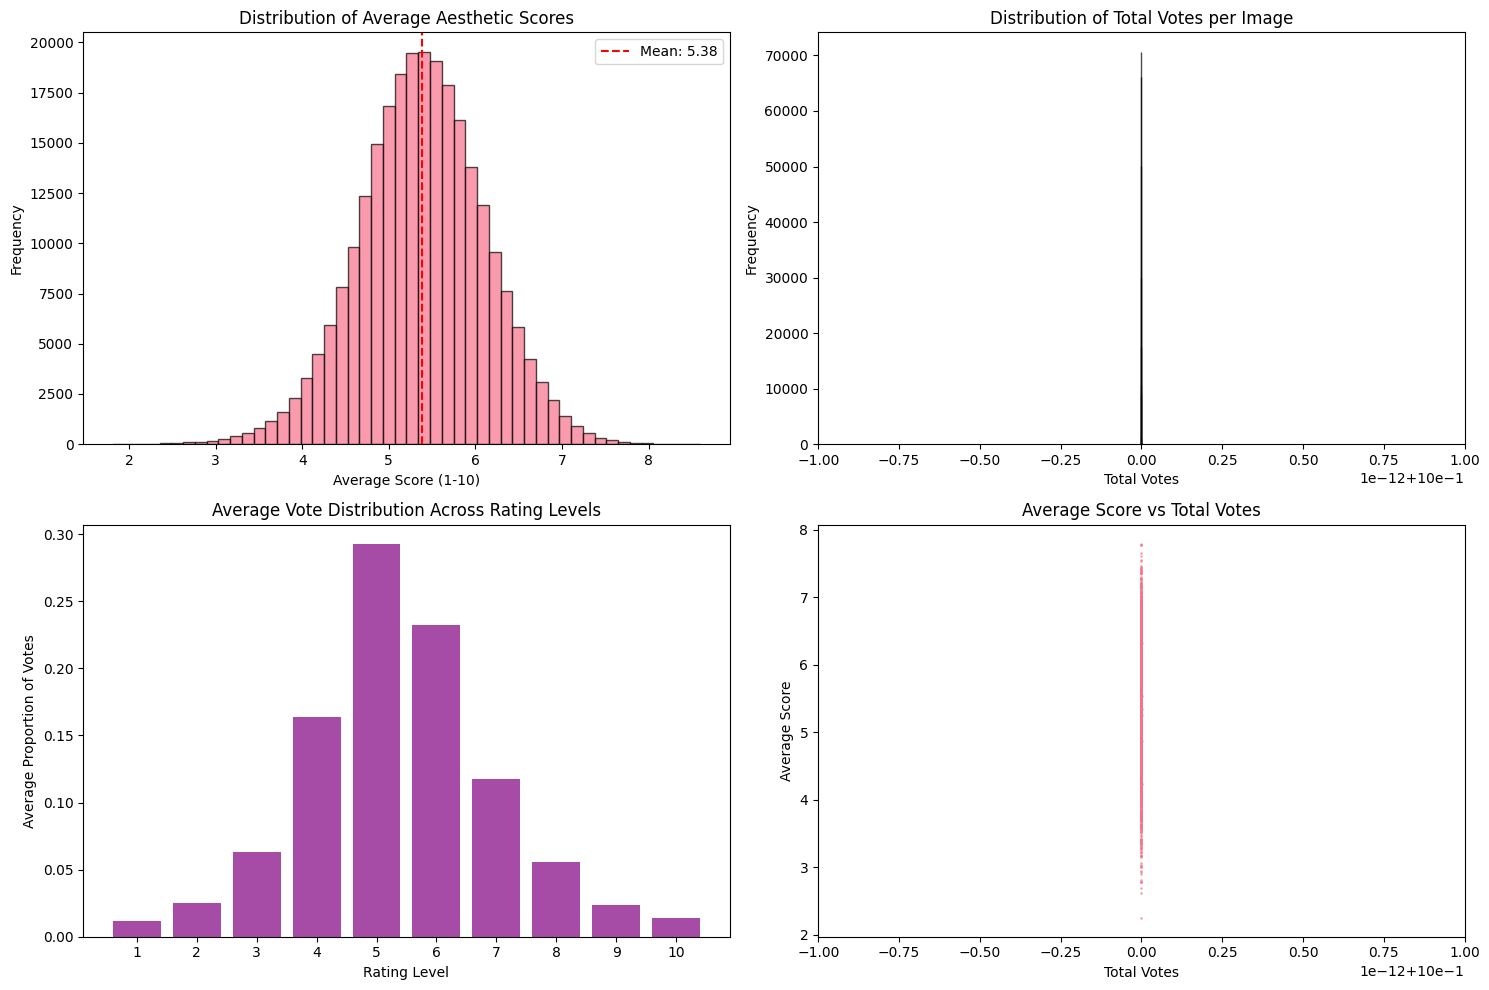

Correlation between average score and vote count: 0.009


In [5]:
# Plot score distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average score distribution
axes[0, 0].hist(df['avg_score'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Average Aesthetic Scores')
axes[0, 0].set_xlabel('Average Score (1-10)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['avg_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["avg_score"].mean():.2f}')
axes[0, 0].legend()

# Vote count distribution
axes[0, 1].hist(df['total_votes'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Distribution of Total Votes per Image')
axes[0, 1].set_xlabel('Total Votes')
axes[0, 1].set_ylabel('Frequency')

# Vote distribution across rating levels
vote_means = df[vote_columns].mean()
axes[1, 0].bar(range(1, 11), vote_means, alpha=0.7, color='purple')
axes[1, 0].set_title('Average Vote Distribution Across Rating Levels')
axes[1, 0].set_xlabel('Rating Level')
axes[1, 0].set_ylabel('Average Proportion of Votes')
axes[1, 0].set_xticks(range(1, 11))

# Score vs Vote Count correlation
sample_df = df.sample(n=min(5000, len(df)))  # Sample for visualization
axes[1, 1].scatter(sample_df['total_votes'], sample_df['avg_score'], alpha=0.5, s=1)
axes[1, 1].set_title('Average Score vs Total Votes')
axes[1, 1].set_xlabel('Total Votes')
axes[1, 1].set_ylabel('Average Score')

plt.tight_layout()
plt.show()

# Print correlation
correlation = df['avg_score'].corr(df['total_votes'])
print(f"Correlation between average score and vote count: {correlation:.3f}")

## 3. Image Dataset Analysis

In [6]:
# Check image files
image_files = list(IMAGES_PATH.glob('*.jpg'))
print(f"Total image files found: {len(image_files)}")
print(f"Images in CSV: {len(df)}")
print(f"Match: {len(image_files) == len(df)}")

# Sample some images to check properties
sample_images = random.sample(image_files, min(100, len(image_files)))
image_properties = []

print("\nAnalyzing sample images...")
for img_path in tqdm(sample_images[:50]):  # Analyze 50 images for speed
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            mode = img.mode
            file_size = img_path.stat().st_size / (1024 * 1024)  # MB
            
            image_properties.append({
                'width': width,
                'height': height,
                'aspect_ratio': width / height,
                'mode': mode,
                'file_size_mb': file_size,
                'megapixels': (width * height) / 1000000
            })
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

img_df = pd.DataFrame(image_properties)
print(f"\nImage Properties (sample of {len(img_df)} images):")
print(img_df.describe())

print(f"\nImage modes: {img_df['mode'].value_counts().to_dict()}")

Total image files found: 255508
Images in CSV: 255508
Match: True

Analyzing sample images...


100%|████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2207.69it/s]


Image Properties (sample of 50 images):
            width      height  aspect_ratio  file_size_mb  megapixels
count   50.000000   50.000000     50.000000     50.000000   50.000000
mean   613.840000  534.000000      1.216542      0.116237    0.323879
std     90.564299  118.273981      0.335186      0.064025    0.069161
min    448.000000  270.000000      0.663818      0.024740    0.136080
25%    559.250000  445.750000      0.850230      0.058323    0.281440
50%    640.000000  486.500000      1.333333      0.121222    0.307200
75%    640.000000  640.000000      1.495353      0.144556    0.354720
max    800.000000  800.000000      1.866667      0.292458    0.501600

Image modes: {'RGB': 50}


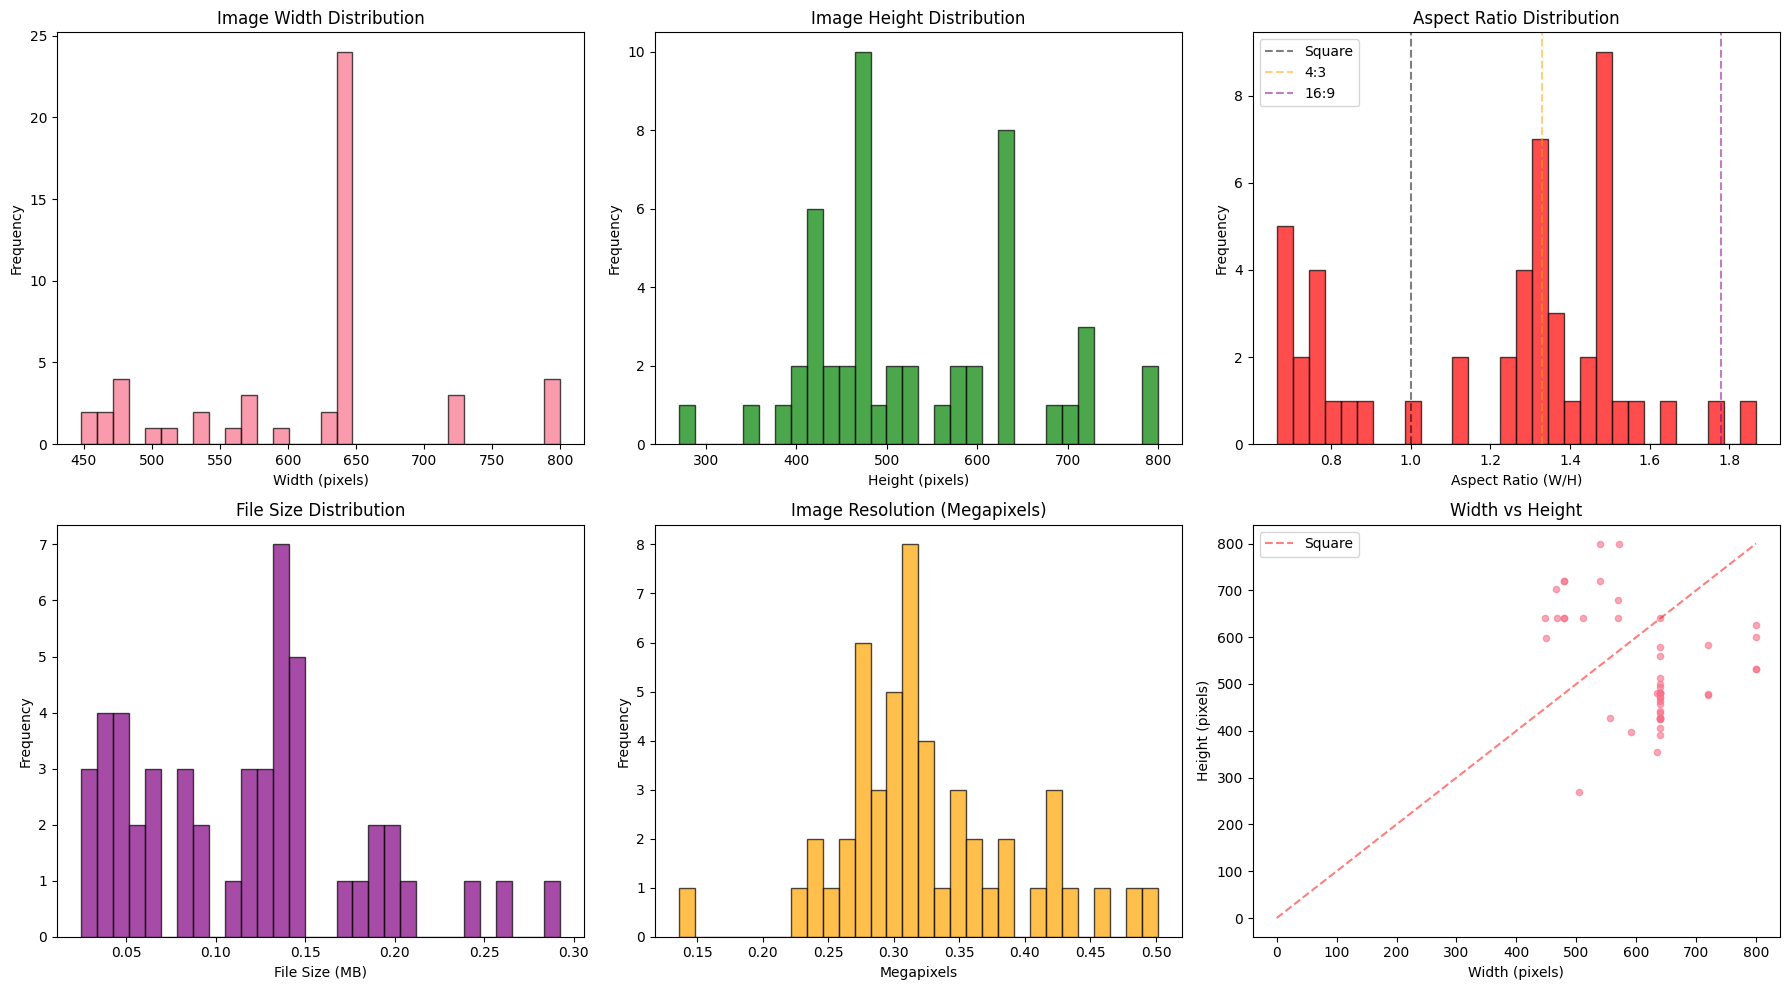

In [7]:
# Visualize image properties
if len(img_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Width distribution
    axes[0, 0].hist(img_df['width'], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Image Width Distribution')
    axes[0, 0].set_xlabel('Width (pixels)')
    axes[0, 0].set_ylabel('Frequency')
    
    # Height distribution
    axes[0, 1].hist(img_df['height'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Image Height Distribution')
    axes[0, 1].set_xlabel('Height (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    
    # Aspect ratio distribution
    axes[0, 2].hist(img_df['aspect_ratio'], bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0, 2].set_title('Aspect Ratio Distribution')
    axes[0, 2].set_xlabel('Aspect Ratio (W/H)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].axvline(1.0, color='black', linestyle='--', alpha=0.5, label='Square')
    axes[0, 2].axvline(1.33, color='orange', linestyle='--', alpha=0.5, label='4:3')
    axes[0, 2].axvline(1.78, color='purple', linestyle='--', alpha=0.5, label='16:9')
    axes[0, 2].legend()
    
    # File size distribution
    axes[1, 0].hist(img_df['file_size_mb'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_title('File Size Distribution')
    axes[1, 0].set_xlabel('File Size (MB)')
    axes[1, 0].set_ylabel('Frequency')
    
    # Megapixels distribution
    axes[1, 1].hist(img_df['megapixels'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Image Resolution (Megapixels)')
    axes[1, 1].set_xlabel('Megapixels')
    axes[1, 1].set_ylabel('Frequency')
    
    # Width vs Height scatter
    axes[1, 2].scatter(img_df['width'], img_df['height'], alpha=0.6, s=20)
    axes[1, 2].set_title('Width vs Height')
    axes[1, 2].set_xlabel('Width (pixels)')
    axes[1, 2].set_ylabel('Height (pixels)')
    
    # Add diagonal line for square images
    max_dim = max(img_df['width'].max(), img_df['height'].max())
    axes[1, 2].plot([0, max_dim], [0, max_dim], 'r--', alpha=0.5, label='Square')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

## 4. Sample Image Visualization

Random sample images:


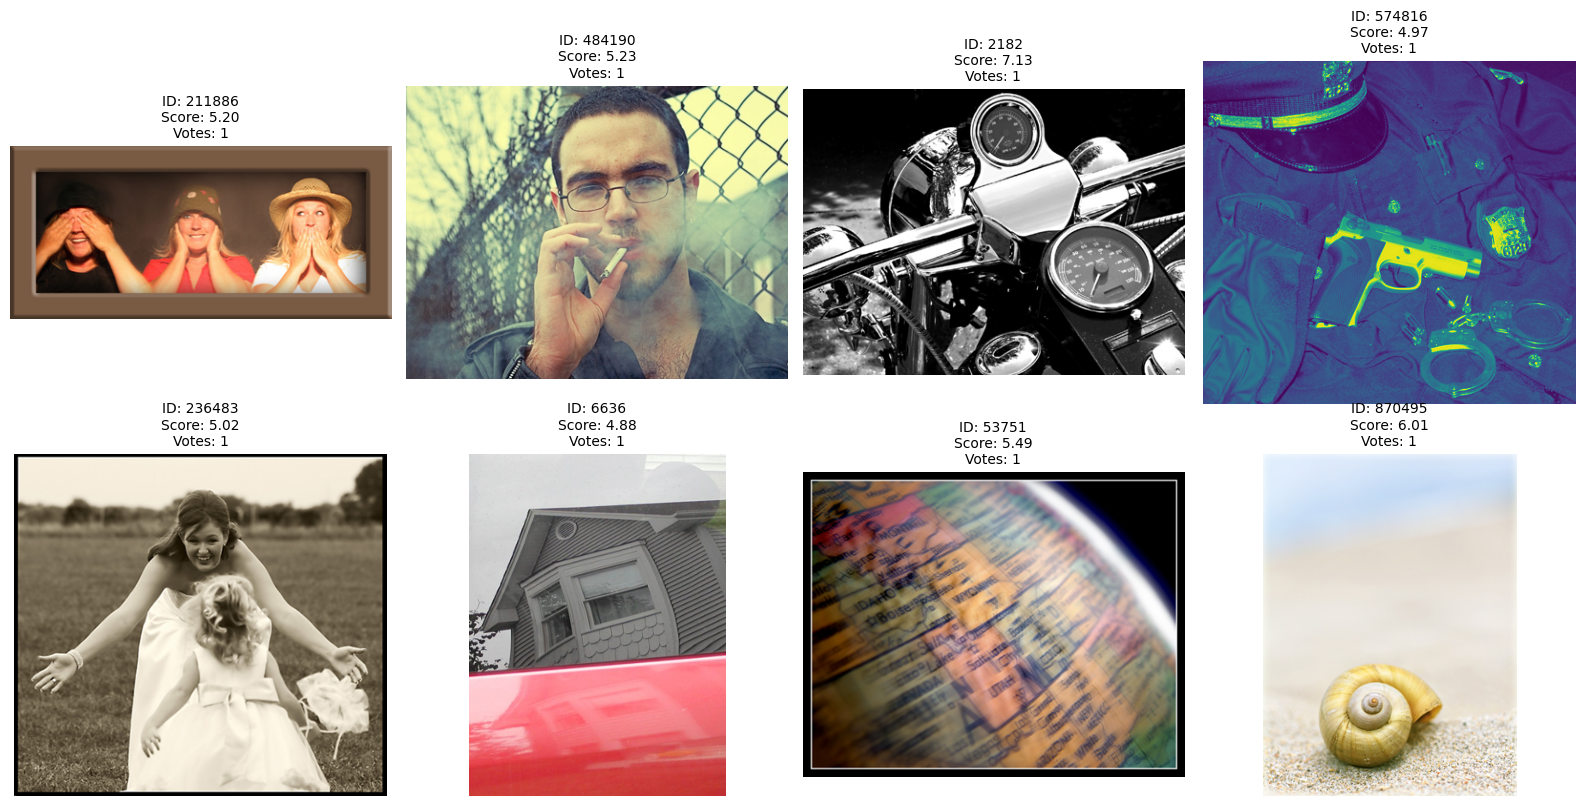

In [8]:
# Show sample images with their scores
def show_sample_images(df, images_path, n_samples=8, score_range=None):
    if score_range:
        filtered_df = df[(df['avg_score'] >= score_range[0]) & (df['avg_score'] <= score_range[1])]
    else:
        filtered_df = df
    
    sample_df = filtered_df.sample(n=min(n_samples, len(filtered_df)))
    
    cols = 4
    rows = (len(sample_df) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        r, c = idx // cols, idx % cols
        
        img_path = images_path / f"{int(row['image_num'])}.jpg"
        
        if img_path.exists():
            try:
                img = Image.open(img_path)
                # Resize for display while maintaining aspect ratio
                img.thumbnail((400, 400))
                
                axes[r, c].imshow(img)
                axes[r, c].axis('off')
                axes[r, c].set_title(
                    f"ID: {int(row['image_num'])}\n"
                    f"Score: {row['avg_score']:.2f}\n"
                    f"Votes: {row['total_votes']:.0f}",
                    fontsize=10
                )
            except Exception as e:
                axes[r, c].text(0.5, 0.5, f"Error loading\n{e}", 
                               ha='center', va='center', transform=axes[r, c].transAxes)
                axes[r, c].axis('off')
        else:
            axes[r, c].text(0.5, 0.5, f"Image not found\n{img_path.name}", 
                           ha='center', va='center', transform=axes[r, c].transAxes)
            axes[r, c].axis('off')
    
    # Hide empty subplots
    for idx in range(len(sample_df), rows * cols):
        r, c = idx // cols, idx % cols
        axes[r, c].axis('off')
    
    plt.tight_layout()
    return fig

# Show random samples
print("Random sample images:")
show_sample_images(df, IMAGES_PATH, n_samples=8)
plt.show()


High-quality images (score > 7.0):
Found 3245 high-quality images (1.3%)


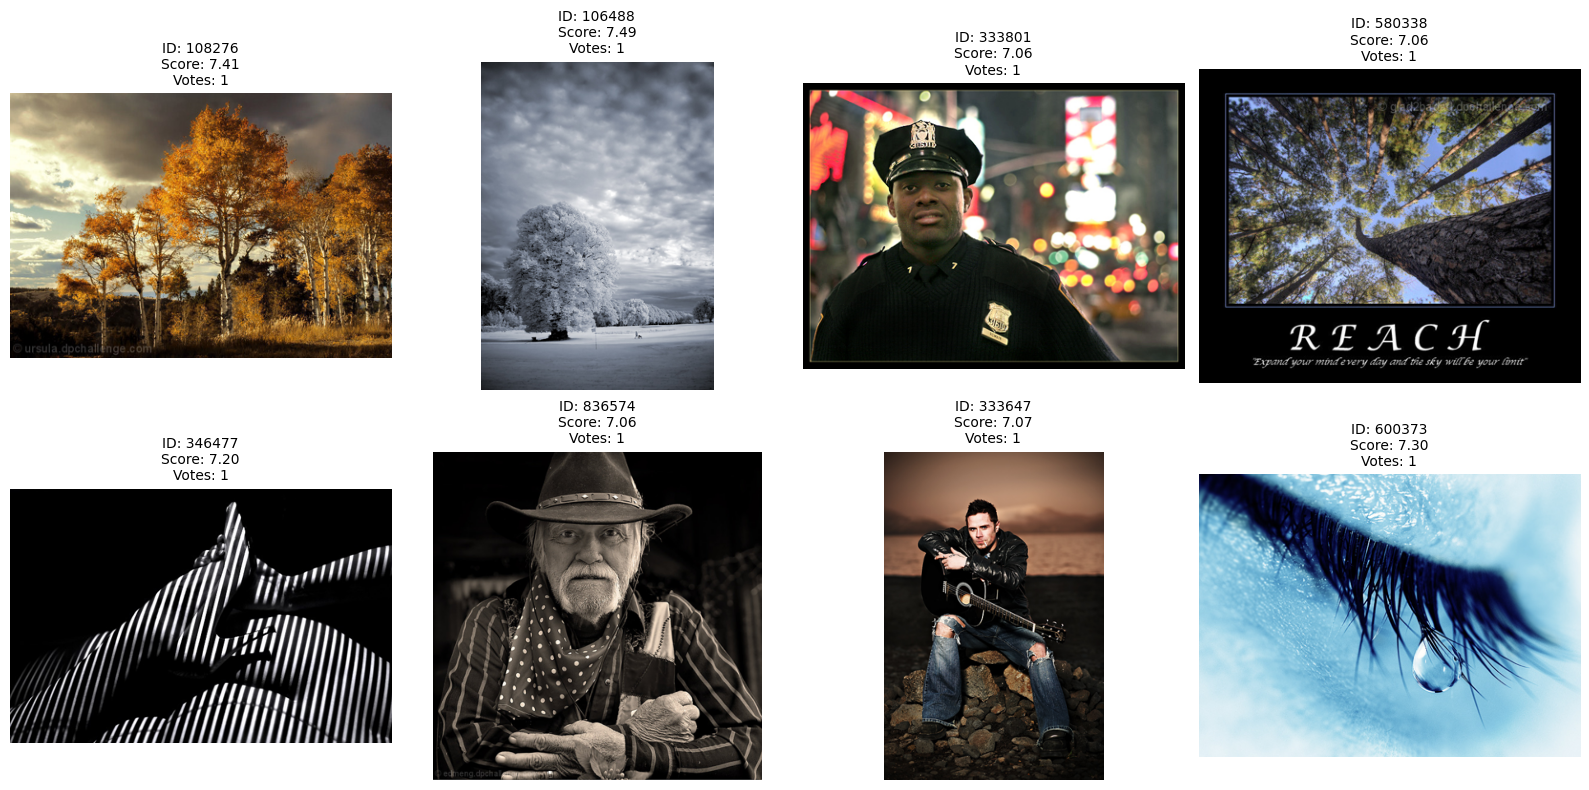


Low-quality images (score < 4.0):
Found 8086 low-quality images (3.2%)


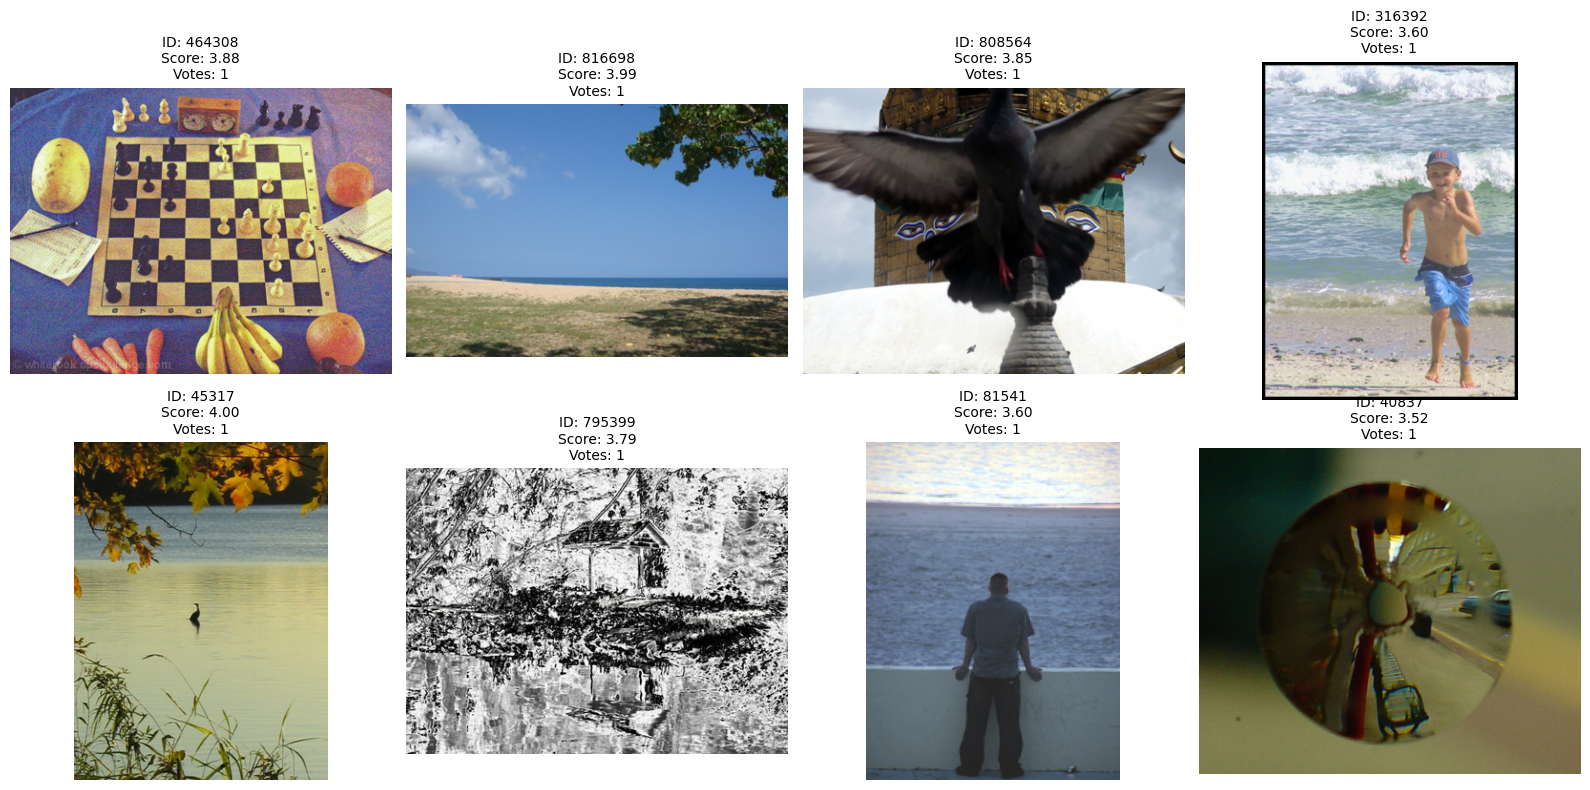

In [9]:
# Show high-quality images (score > 7)
print("\nHigh-quality images (score > 7.0):")
high_quality = df[df['avg_score'] > 7.0]
print(f"Found {len(high_quality)} high-quality images ({len(high_quality)/len(df)*100:.1f}%)")
if len(high_quality) > 0:
    show_sample_images(df, IMAGES_PATH, n_samples=8, score_range=(7.0, 10.0))
    plt.show()

# Show low-quality images (score < 4)
print("\nLow-quality images (score < 4.0):")
low_quality = df[df['avg_score'] < 4.0]
print(f"Found {len(low_quality)} low-quality images ({len(low_quality)/len(df)*100:.1f}%)")
if len(low_quality) > 0:
    show_sample_images(df, IMAGES_PATH, n_samples=8, score_range=(1.0, 4.0))
    plt.show()

## 5. Summary and Next Steps

### Dataset Overview:
- **Size**: 255,510 images with aesthetic ratings
- **Ratings**: Vote distribution across 10 quality levels (1-10)
- **Score Range**: Typically 3-8 with normal distribution
- **Images**: Various resolutions and aspect ratios

### Key Insights:
1. **Score Distribution**: Most images fall in the 4-6 range (average quality)
2. **Vote Reliability**: Images with more votes tend to have more reliable scores
3. **Image Diversity**: Wide variety of resolutions and aspect ratios
4. **Quality Categories**: Clear distinction between high/low quality images

### Next Steps for Model Development:
1. **Data Preprocessing**: Resize images to consistent dimensions (224x224 or 256x256)
2. **Score Normalization**: Convert 1-10 scores to 0-100 range for backend compatibility
3. **Train/Val/Test Split**: 70/15/15 split with stratification by score ranges
4. **Data Augmentation**: Random crops, flips, rotations to increase dataset size
5. **Model Architecture**: Start with pretrained ResNet50, fine-tune for aesthetic prediction
6. **Loss Function**: MSE or smooth L1 loss for regression task
7. **Evaluation Metrics**: MAE, RMSE, and correlation with human ratings

In [10]:
# Export key statistics for model development
stats_summary = {
    'total_images': len(df),
    'score_mean': df['avg_score'].mean(),
    'score_std': df['avg_score'].std(),
    'score_min': df['avg_score'].min(),
    'score_max': df['avg_score'].max(),
    'high_quality_count': len(df[df['avg_score'] > 7.0]),
    'low_quality_count': len(df[df['avg_score'] < 4.0]),
    'avg_votes_per_image': df['total_votes'].mean(),
}

if len(img_df) > 0:
    stats_summary.update({
        'avg_width': img_df['width'].mean(),
        'avg_height': img_df['height'].mean(),
        'avg_aspect_ratio': img_df['aspect_ratio'].mean(),
        'avg_file_size_mb': img_df['file_size_mb'].mean(),
        'avg_megapixels': img_df['megapixels'].mean(),
    })

print("Dataset Statistics Summary:")
for key, value in stats_summary.items():
    print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")

# Save summary for next steps
import json
with open('../ai-service/dataset_stats.json', 'w') as f:
    json.dump(stats_summary, f, indent=2)

print("\n✅ Statistics saved to ai-service/dataset_stats.json")
print("\n🚀 Ready to proceed with model development!")

Dataset Statistics Summary:
total_images: 255508
score_mean: 5.383
score_std: 0.731
score_min: 1.809
score_max: 8.600
high_quality_count: 3245
low_quality_count: 8086
avg_votes_per_image: 1.000
avg_width: 613.840
avg_height: 534.000
avg_aspect_ratio: 1.217
avg_file_size_mb: 0.116
avg_megapixels: 0.324

✅ Statistics saved to ai-service/dataset_stats.json

🚀 Ready to proceed with model development!
